# preparing and understanding the data

here we will pass the data by a several  process to prepare it before start the training process


lets start by importing the DataGen that contains some useful functions to work the data 

In [1]:
import DataGen
from os import listdir
from os.path import isfile, join 
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

%matplotlib inline
%load_ext autoreload 

Using TensorFlow backend.


In [2]:
DataGen.decompress_dataset()

data already decompressed


now lets create a list with the files from the test set 

In [3]:

files = []
for name in ['a', 'b', 'c', 'd', 'e']:
    path = "./decompressed_dataset/"+name+"_test/jpg"
    files = files + [join(path, f) for f in listdir(path) if isfile(join(path, f))]


lets choose an image at random to test our process

In [4]:

image_path = random.choice(files)


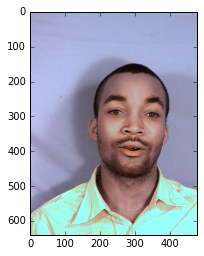

In [5]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

lets check the landmarks positions for that we nee to get the labels loaded

In [6]:
labels = DataGen.load_labels()
image_name = image_path.split("/")[-1].split(".")[0]
label = labels.loc[labels['name'] == image_name].values.tolist()[0][2:]

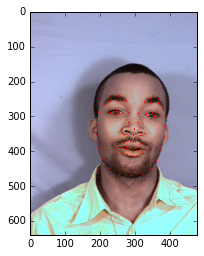

In [7]:
for i in range(0,151,2):
    cv2.circle(image, (int(label[i]),int(label[i+1]) ), 2, (255, 0, 0), -1)
plt.imshow(image)

now lets crop the image and see the result

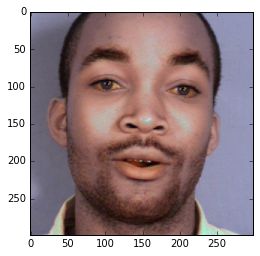

In [8]:
%autoreload
image2 = cv2.imread(image_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
croped_image, box = DataGen.crop_image(image2, 299)
croped_label = DataGen.replace_landmarks(box, label) 
plt.imshow(croped_image)


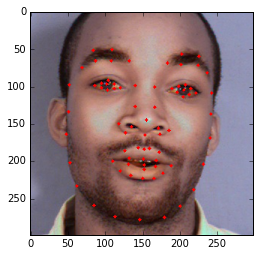

In [9]:
copy_of_croped_image = croped_image
for i in range(0,151,2):
    cv2.circle(copy_of_croped_image, (int(croped_label[i]),int(croped_label[i+1]) ), 2, (255, 0, 0), -1)
plt.imshow(copy_of_croped_image)

now lets test the flipping of a image

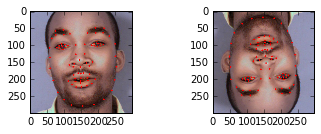

In [10]:
hflip = DataGen.flip_image(croped_image, croped_label, 1, 299, 299)
vflip = DataGen.flip_image(croped_image, croped_label, 0, 299, 299)
for i in range(0,151,2):
    cv2.circle(hflip[0], (int(hflip[1][i]),int(hflip[1][i+1]) ), 2, (255, 0, 0), -1)
    cv2.circle(vflip[0], (int(vflip[1][i]),int(vflip[1][i+1]) ), 2, (255, 0, 0), -1)


fig = plt.figure()
plt.subplot(221)
plt.imshow(hflip[0])
plt.subplot(222)
plt.imshow(vflip[0])
plt.show()

time to process the all images and create the data set

In [33]:
%autoreload
dataset = DataGen.create_dataset(299, flip_horizontal=True, flip_vertical=True)
print("total of train images = "+str(len(dataset["train_set"])))
print("total of test images = "+str(len(dataset["test_set"])))
DataGen.save_dataset(dataset, "299_dataset.npz")

100% (100.0 of 100) |#####################| Elapsed Time: 0:03:28 ETA:  0:00:008:23:2647

total of train images = 7515
total of test images = 3735
3051717178


In [11]:
dataset = np.load("299_dataset.npz")

In [4]:
%autoreload

DataGen.inception_bottleneck(dataset["train_x"], "inception_train.npy")
DataGen.inception_bottleneck(dataset["test_x"], "inception_test.npy")

 128/7515 [..............................] - ETA: 1833s

KeyboardInterrupt: 

In [36]:
train_x = np.load("inception_train.npy")
test_x = np.load("inception_test.npy")

train_y = dataset["train_y"]/299
test_y = dataset["test_y"]/299

#for x in np.transpose(dataset["train_y"]/299):
    #train_y.append(x)
    
#for x in np.transpose(dataset["test_y"]/299):
    #test_y.append(x)




In [35]:
test = np.array([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]])
print(np.transpose(test))

[[ 1  6 11]
 [ 2  7 12]
 [ 3  8 13]
 [ 4  9 14]
 [ 5 10 15]]


In [90]:
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, Input
from keras.models import Sequential, Model
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True)

checkpointer = ModelCheckpoint(filepath='best.inception.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='loss', patience=15)





outputs = []
inputs = Input(shape=train_x.shape[1:])
model = Dense(1000,kernel_initializer='uniform',activation='tanh')(inputs)
model = Dense(1024,kernel_initializer='uniform',activation='tanh')(model)
model = Dense(1024,kernel_initializer='uniform',activation='tanh')(model)
model = Dense(512,kernel_initializer='uniform',activation='tanh')(model)
output = Dense(152,kernel_initializer='uniform', activation='linear')(model)

#for i in range(0,152):
    #outputs.append(Dense(1,kernel_initializer='uniform', activation='linear')(model))

print(len(outputs))

model = Model(inputs=[inputs], outputs=[output])

sgd = optimizers.SGD(lr=0.3,  momentum=0.5, decay=0.1, nesterov=True)

model.compile(loss='mse', optimizer=sgd,metrics=['acc'])

print(model.summary())


0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_502 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_503 (Dense)            (None, 1024)              1025024   
_________________________________________________________________
dense_504 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_505 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_506 (Dense)            (None, 152)               77976     
Total params: 3,678,400
Trainable params: 3,678,400
Non-trainable params: 0
________________________________________________________________

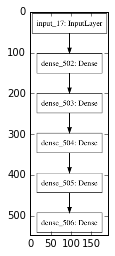

In [91]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

plt.imshow(cv2.imread("model.png"))

In [92]:
model.fit(train_x, train_y, validation_data=(test_x,test_y), callbacks=[checkpointer,tbCallBack,early_stopping], epochs=1000, batch_size=10, verbose=1, shuffle=True)

Train on 7515 samples, validate on 3735 samples
Epoch 1/1000
7515/7515 [==============================] - 25s - loss: 0.0441 - acc: 0.3289 - val_loss: 0.0386 - val_acc: 0.3722
Epoch 2/1000
7515/7515 [==============================] - 22s - loss: 0.0384 - acc: 0.3701 - val_loss: 0.0384 - val_acc: 0.3722
Epoch 3/1000
7515/7515 [==============================] - 22s - loss: 0.0382 - acc: 0.3701 - val_loss: 0.0383 - val_acc: 0.3722
Epoch 4/1000
7515/7515 [==============================] - 23s - loss: 0.0382 - acc: 0.3699 - val_loss: 0.0383 - val_acc: 0.3722
Epoch 5/1000
7515/7515 [==============================] - 23s - loss: 0.0381 - acc: 0.3702 - val_loss: 0.0383 - val_acc: 0.3724
Epoch 6/1000
7515/7515 [==============================] - 23s - loss: 0.0381 - acc: 0.3702 - val_loss: 0.0382 - val_acc: 0.3724
Epoch 7/1000
7515/7515 [==============================] - 23s - loss: 0.0381 - acc: 0.3702 - val_loss: 0.0382 - val_acc: 0.3724
Epoch 8/1000
7515/7515 [==============================] 

7515/7515 [==============================] - 22s - loss: 0.0379 - acc: 0.3702 - val_loss: 0.0381 - val_acc: 0.3724
Epoch 29/1000
7515/7515 [==============================] - 23s - loss: 0.0379 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 30/1000
7515/7515 [==============================] - 23s - loss: 0.0379 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 31/1000
7515/7515 [==============================] - 24s - loss: 0.0379 - acc: 0.3701 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 32/1000
7515/7515 [==============================] - 23s - loss: 0.0379 - acc: 0.3701 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 33/1000
7515/7515 [==============================] - 23s - loss: 0.0379 - acc: 0.3701 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 34/1000
7515/7515 [==============================] - 25s - loss: 0.0379 - acc: 0.3701 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 35/1000
7515/7515 [==============================] - 24s - loss: 0.0379 - acc: 0.3701 - val_loss: 0.0380 

7515/7515 [==============================] - 24s - loss: 0.0379 - acc: 0.3701 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 56/1000
7515/7515 [==============================] - 24s - loss: 0.0379 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 57/1000
7515/7515 [==============================] - 24s - loss: 0.0379 - acc: 0.3701 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 58/1000
7515/7515 [==============================] - 24s - loss: 0.0379 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 59/1000
7515/7515 [==============================] - 23s - loss: 0.0379 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 60/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 61/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 62/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 

7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 83/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 84/1000
7515/7515 [==============================] - 22s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 85/1000
7515/7515 [==============================] - 22s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 86/1000
7515/7515 [==============================] - 22s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 87/1000
7515/7515 [==============================] - 22s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 88/1000
7515/7515 [==============================] - 22s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 89/1000
7515/7515 [==============================] - 22s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 

7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 110/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 111/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 112/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 113/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 114/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 115/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0380 - val_acc: 0.3724
Epoch 116/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 137/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 138/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 139/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 140/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 141/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 142/1000
7515/7515 [==============================] - 22s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 143/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 164/1000
7515/7515 [==============================] - 23s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 165/1000
7515/7515 [==============================] - 25s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 169/1000
7515/7515 [==============================] - 25s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 170/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 171/1000
7515/7515 [==============================] - 25s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 172/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 173/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 194/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 195/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 196/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 197/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 198/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 199/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 200/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 221/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 222/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 223/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 224/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 225/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 226/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 227/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 248/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 249/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 250/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 251/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 252/1000
7515/7515 [==============================] - 22s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 253/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 254/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 275/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 276/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 277/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 278/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 279/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 280/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 281/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 302/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 303/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 304/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 305/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 306/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 307/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 308/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 329/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 330/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 331/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 332/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 333/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 334/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 335/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 356/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 357/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 358/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 359/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 360/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 361/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 362/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 383/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 384/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 385/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 386/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 387/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 388/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 389/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 410/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 411/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 412/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 413/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 414/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 415/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 416/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 437/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 438/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 439/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 440/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 441/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 442/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 443/1000
7515/7515 [==============================] - 24s - loss: 0.0378 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 464/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 465/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 466/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 467/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 468/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 469/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 470/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 491/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 492/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 493/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 494/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 495/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 496/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 497/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 518/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 519/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 520/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 521/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 522/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 523/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 524/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 545/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 546/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 547/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 548/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 549/1000
7515/7515 [==============================] - 23s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 550/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 551/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 21s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 572/1000
7515/7515 [==============================] - 25s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 573/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 574/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 575/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 576/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 577/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 578/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 599/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 600/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 601/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 602/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 603/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 604/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 605/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 626/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 627/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 628/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 629/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 630/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 631/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 632/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 653/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 654/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 655/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 656/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 657/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 658/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 659/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 23s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 680/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 681/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 682/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 683/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 684/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 685/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 686/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 707/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 708/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 709/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 710/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 711/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 712/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 713/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 734/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 735/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 736/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 737/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 738/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 739/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 740/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 761/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 762/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 763/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 764/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 765/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 766/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 767/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 788/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 789/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 790/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 791/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 792/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 793/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 794/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 815/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 816/1000
7515/7515 [==============================] - 23s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 817/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 818/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 819/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 820/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 821/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 842/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 843/1000
7515/7515 [==============================] - 23s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 844/1000
7515/7515 [==============================] - 23s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 845/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 846/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 847/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 848/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 869/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 870/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 871/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 872/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 873/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 874/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 875/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 896/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 897/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 898/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 899/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 900/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 901/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 902/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 923/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 924/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 925/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 926/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 927/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 928/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 929/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 950/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 951/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 952/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 953/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 954/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 955/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3722
Epoch 956/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 977/1000
7515/7515 [==============================] - 23s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 978/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 979/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 980/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 981/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 982/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 0.0379 - val_acc: 0.3724
Epoch 983/1000
7515/7515 [==============================] - 24s - loss: 0.0377 - acc: 0.3702 - val_loss: 

In [93]:
model.load_weights("best.inception.hdf5")  

In [94]:
from keras.applications.inception_v3 import InceptionV3

In [95]:
incep = InceptionV3(weights='imagenet')

[ 115.34937286  128.94415283  107.98600769  140.53393555  116.21173859
  150.27471924  111.6634903   164.4249115   119.90692139  173.19038391
  128.11494446  182.75914001  145.32713318  185.49967957  145.92446899
  188.7964325   156.28326416  178.31520081  156.27482605  174.11515808
  162.65686035  177.74153137  160.40733337  160.7303772   170.00714111
  153.64553833  174.32118225  138.36871338  164.75752258  139.38290405
  150.37969971   98.58907318  162.94767761  115.72073364  163.1504364
  118.12126923  150.97897339  116.49272156  159.01800537  123.65211487
  163.853302    119.94841766  127.40971375  125.24506378  131.62860107
  115.71813202  131.02064514  119.84455872  149.72436523  121.52365875
  132.15213013  126.58131409  126.65891266  121.02446747  131.09890747
  127.56430054  140.08491516  123.63072968  139.33169556  125.86357117
  134.89282227  136.47782898  126.72438812  124.66815948  162.74543762
  124.71850586  161.77630615  117.08302307  155.79771423  136.64375305
  150.8

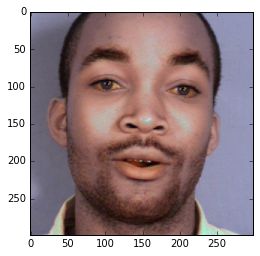

In [96]:



image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
croped_image, box = DataGen.crop_image(image, 299)

plt.imshow(croped_image)



img = np.array([image])
btl = incep.predict(img)
pred = model.predict(btl)


pred = pred*299
print(pred[0])

In [97]:

for i in range(0,151,2):
    cv2.circle(image, (int(pred[0][i]),int(pred[0][i+1]) ), 2, (255, 0, 0), -1)

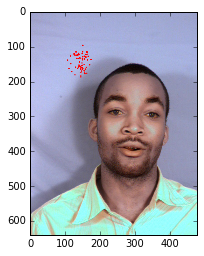

In [98]:
plt.imshow(image)